In [147]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandana.loaders import osm
import pandana
%pylab inline

import numpy as np
import osmnx as ox
import networkx as nx
import peartree
import sys, os
import geopandas as gpd
import folium
import rasterio
from pandana.loaders import osm
from shapely.geometry import Point
import mplleaflet as mpll
from osgeo import ogr
from math import ceil, cos, pi
import geocoder

from make_fishnet import make_fishnet
import GOSTnet as gn

from shapely.geometry import mapping, Polygon, box
import fiona

Populating the interactive namespace from numpy and matplotlib


In [186]:
pth = '/Users/nicholasjones/Desktop/code/MENA/data/saudi_maps/'

In [208]:
def make_gdf(file_name):
    shp = pd.read_csv(os.path.join(pth, file_name))
    shp = shp[['Name_E','E','N','Area_m2']]
    shp['geometry'] = (list(zip(shp.E,shp.N)))
    shp['geometry'] = shp.geometry.apply(lambda x: Point(x))
    shp = gpd.GeoDataFrame(shp, crs = {'init' :'epsg:4326'})
    return(shp)

In [209]:
parks_madinah = make_gdf('madinah_parks.csv')
parks_dammam = make_gdf('dammam_parks.csv')
parks_jeddah = make_gdf('jeddah_parks.csv')
parks_makkah = make_gdf('makkah_parks.csv')
parks_riyadh = make_gdf('riyadh_parks.csv')

In [247]:
def get_bounds(parks_gdf, buffer_fraction):
    '''parks_gdf: geodataframe of parks
       buffer_fraction: fraction of bounding box dimensions by which to buffer (between 0 to 1)'''
    bounds = parks_gdf.unary_union.bounds
    x_width = abs(bounds[2] - bounds[0])
    y_height = abs(bounds[3] - bounds[1])
    minx = bounds[0] - (x_width * buffer_fraction)
    miny = bounds[1] + (y_height * buffer_fraction)
    maxx = bounds[2] - (x_width * buffer_fraction)
    maxy = bounds[3] + (y_height * buffer_fraction)
    return(minx, miny, maxx, maxy)

In [269]:
def create_network(pois_gdf, bounding_increment):
    coords = get_bounds(pois_gdf, bounding_increment)
    coords = (coords[1],coords[0],coords[3],coords[2])
    return(osm.pdna_network_from_bbox(*coords))

In [303]:
%%time
print(1)

1
CPU times: user 249 µs, sys: 136 µs, total: 385 µs
Wall time: 271 µs


In [304]:
%%time

G_dammam = create_network(parks_dammam, 0.2)
G_madinah = create_network(parks_madinah, 0.2)
G_jeddah = create_network(parks_jeddah, 0.2)
G_makkah = create_network(parks_makkah, 0.2)
G_riyadh = create_network(parks_riyadh, 0.2)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](26.37420000,49.95993600,26.51535000,50.16285600);>;);out;'}"
Downloaded 4,359.5KB from www.overpass-api.de in 2.35 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 2.51 seconds
Returning OSM data with 31,426 nodes and 8,771 ways...
Edge node pairs completed. Took 16.82 seconds
Returning processed graph with 17,177 nodes and 26,433 edges...
Completed OSM data download and Pandana node and edge table creation in 21.32 seconds
Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|pro

In [273]:
fig_kwargs={'figsize': [10,10]}
bmap_kwargs={'suppress_ticks': False,'epsg': '4326'}
plot_kwargs={'cmap': 'viridis', 's': 8, 'edgecolor': 'none'}
hex_plot_kwargs = {'gridsize':40,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

In [ ]:
network.

#### 3. Plot accessibility from any node to nearest amenity

In [308]:
def plot_accessibility(network, pois_gdf, distance, n, city_name):
    network.precompute(distance) 
    network.set_pois(category='all', maxdist = distance,x_col=pois_gdf['E'], maxitems=1, y_col=pois_gdf['N'])
    access_table = network.nearest_pois(distance=distance, category='all', num_pois=1)
    bmap, fig, ax = network.plot(access_table[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
    ax.set_facecolor('k')
    ax.set_title('{}: Driving distance to nearest park, meters)'.format(city_name), fontsize=14);

In [355]:
def plot_accessibility_and_roads(network, pois_gdf, distance, n, city_name,
                                 highway = ['motorway','trunk','primary','secondary'],
                                 bounding_increment = 0.2):
    network.precompute(distance) 
    network.set_pois(category='all', maxdist = distance,x_col=pois_gdf['E'], maxitems=1, y_col=pois_gdf['N'])
    access_table = network.nearest_pois(distance=distance, category='all', num_pois=1)
    bmap, fig, ax = network.plot(access_table[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
    ax.set_facecolor('k')
    ax.set_title('{}: Driving distance to nearest park, meters)'.format(city_name), fontsize=14);

    coords = get_bounds(pois_gdf, bounding_increment)
    G_roads = ox.graph_from_bbox(coords[3],coords[1],coords[2],coords[0])
    gdf_roads = ox.graph_to_gdfs(G_roads, nodes=False, edges = True)
    gdf_roads['highway'] = gdf_roads.highway.astype(str)
    gdf_roads[gdf_roads.highway.isin(['motorway','trunk','primary'])].plot(ax = ax, color = 'w', alpha = 0.5)

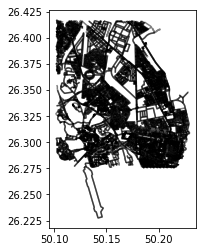

In [350]:
coords = get_bounds(parks_dammam, -0.5)
G_roads = ox.graph_from_bbox(coords[3],coords[1],coords[2],coords[0])
gdf_roads = ox.graph_to_gdfs(G_roads, nodes=False, edges = True)
gdf_roads['highway'] = gdf_roads.highway.astype(str)
gdf_roads.plot(color = 'k', alpha = 0.5)

In [ ]:
parks_jeddah.plot(marker = '.', markersize = 40,figsize = [8,8])

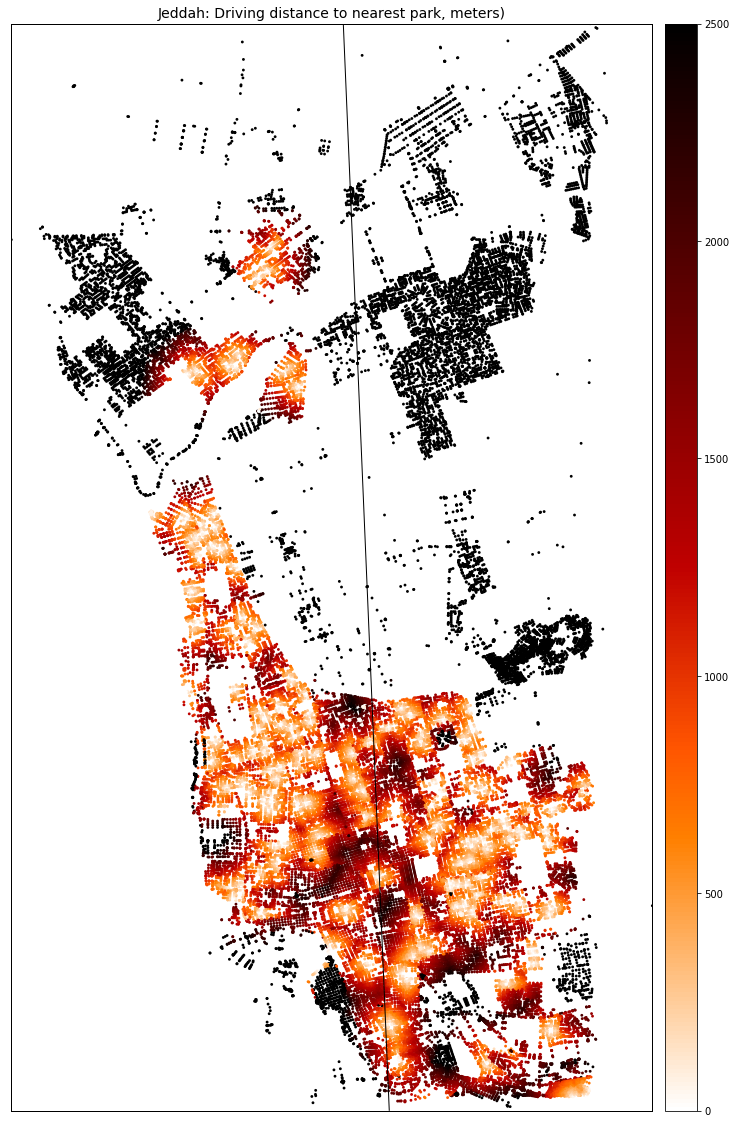

In [413]:
def plot_Jeddah(network, pois_gdf, distance, n, city_name,
                                 highway = ['motorway','trunk','primary','secondary'],
                                 bounding_increment = 0.2):
    
    plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'}
    fig_kwargs = {'figsize': [20, 20]}
    #bmap_kwargs = {'suppress_ticks': False, 'resolution': 'h', 'epsg': '20440'}
    
    network.precompute(distance) 
    network.set_pois(category='all', maxdist = distance,x_col=pois_gdf['E'], maxitems=1, y_col=pois_gdf['N'])
    access_table = network.nearest_pois(distance=distance, category='all', num_pois=1)
    bmap, fig, ax = network.plot(access_table[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
    ax.set_facecolor('w')
    ax.set_title('{}: Driving distance to nearest park, meters)'.format(city_name), fontsize=14);
    #pois_gdf.plot(marker = 'x',markersize = 100, color = 'c', ax = ax)
    return(network, access_table)
    
network, access_table = plot_Jeddah(G_jeddah, parks_jeddah, 2500, 1, 'Jeddah')

In [405]:
network_gdf = network.nodes_df


In [412]:
print(network_gdf.shape, access_table.shape)

(44879, 2) (44879, 2)


In [414]:
network_gdf['distance'] = access_table

In [460]:
network_gdf['geometry'] = (list(zip(network_gdf.x,network_gdf.y)))
network_gdf['geometry'] = network_gdf.geometry.apply(lambda x: Point(x))

In [439]:
network_gdf = gpd.GeoDataFrame(network_gdf)

In [440]:
network_gdf.x.describe()

count    44879.000000
mean        39.177903
std          0.047968
min         39.036003
25%         39.142124
50%         39.184621
75%         39.215022
max         39.282534
Name: x, dtype: float64

In [447]:
os.path.join(pth, "jeddah_shp")

'/Users/nicholasjones/Desktop/code/MENA/data/saudi_maps/jeddah_shp'

In [452]:
! ls data/saudi_maps/jeddah_shp

jeddah_shp.cpg jeddah_shp.dbf jeddah_shp.shp jeddah_shp.shx


In [461]:
network_gdf_sm = network_gdf[::20]

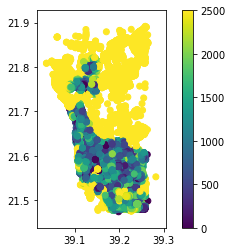

In [448]:
network_gdf.plot(column = 'distance', legend = True)
network_gdf.to_file(os.path.join(pth, "jeddah_shp"))

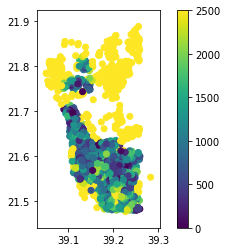

In [462]:
network_gdf_sm.plot(column = 'distance', legend = True)
network_gdf_sm.to_file(os.path.join(pth, "jeddah_SM_shp"))

In [464]:
import mplleaflet as mpll

In [471]:
network_gdf_sm.crs = {'init' :'epsg:4326'}
network_gdf_sm.to_crs(epsg = '20440')

x          y     distance  \
id                                              
287894981   39.152753  21.630046   972.318970   
289244719   39.166558  21.577636  2390.298096   
292262619   39.158164  21.523231  2500.000000   
292263927   39.159066  21.529212  2500.000000   
292271995   39.156890  21.528503  2500.000000   
292272100   39.162289  21.511671  2500.000000   
292619982   39.190926  21.688947  2500.000000   
297309360   39.155761  21.535858  2500.000000   
307628244   39.193600  21.536327    58.771000   
307628415   39.186509  21.530906   590.161987   
307628772   39.195415  21.532306  1019.565979   
307629247   39.191494  21.539067   801.351013   
322578806   39.208616  21.483708  1584.055054   
346202365   39.100732  21.681632  1212.042969   
346208153   39.163071  21.633593  2078.826904   
354668208   39.226038  21.488149  1042.785034   
354669700   39.219773  21.511848  2332.885010   
450875943   39.158451  21.601164  1496.855957   
455462097   39.142861  21.551127  1376.980957   
455482442   39.152512  21.549632  1508.522949   
457869838   39.132308  21.542269  1884.708008   
473394050   39.103554  21.662140   391.290985   
473397426   39.180117  21.527334  1041.475952   
474790510   39.191902  21.501092  1373.612061   
492938526   39.110318  21.684502  1139.442993   
493001605   39.130113  21.671451  1985.463989   
493001718   39.126863  21.686039  2500.000000   
493056294   39.207231  21.479567  1880.057007   
498886492   39.176179  21.527982   861.562988   
506314692   39.151381  21.663774  2500.000000   
...               ...        ...          ...   
6387496264  39.245224  21.646497  2500.000000   
6387496310  39.243837  21.646124  2500.000000   
6387504557  39.253355  21.651642  2500.000000   
6387518299  39.247146  21.654152  2500.000000   
6387518330  39.243216  21.654335  2500.000000   
6387518354  39.242307  21.654832  2500.000000   
6387518378  39.241237  21.654589  2500.000000   
6387583475  39.240970  21.653700  2500.000000   
6387583798  39.237819  21.654142  2500.000000   
6387583823  39.238084  21.653870  2500.000000   
6387583858  39.233904  21.655305  2500.000000   
6387583913  39.249676  21.662137  2500.000000   
6387604597  39.252158  21.662129  2500.000000   
6387604619  39.250622  21.662201  2500.000000   
6387604646  39.255935  21.659929  2500.000000   
6387604682  39.252681  21.655079  2500.000000   
6387604711  39.255381  21.654138  2500.000000   
6387604731  39.255636  21.653022  2500.000000   
6387604769  39.255497  21.647526  2500.000000   
6387615654  39.256037  21.656205  2500.000000   
6387615677  39.256031  21.659563  2500.000000   
6387615825  39.257519  21.655945  2500.000000   
6387632547  39.257635  21.660758  2500.000000   
6387632573  39.254965  21.660127  2500.000000   
6387649927  39.232847  21.639305  2500.000000   
6387661204  39.231279  21.659188  2500.000000   
6387661233  39.234991  21.658637  2500.000000   
6387661260  39.243996  21.658337  2500.000000   
6387661298  39.245210  21.658723  2500.000000   
6387661341  39.242749  21.656650  2500.000000   

                                                geometry  
id                                                        
287894981   POINT (-1369073.730713717 2501635.097032761)  
289244719   POINT (-1368305.670492683 2495448.770676613)  
292262619   POINT (-1369944.259399716 2489315.301461988)  
292263927   POINT (-1369766.435294914 2489989.827651095)  
292271995    POINT (-1370009.57822095 2489936.150424655)  
292272100   POINT (-1369658.199410331 2487937.092200958)  
292619982   POINT (-1364179.434160432 2507903.771556592)  
297309360   POINT (-1370030.977128018 2490794.073209469)  
307628244   POINT (-1365964.326711939 2490368.332329103)  
307628415    POINT (-1366798.598859182 2489836.42276421)  
307628772   POINT (-1365823.916134882 2489884.300957425)  
307629247   POINT (-1366153.212452663 2490709.209108254)  
322578806   POINT (-1365063.586527104 2484144.146505309)  
346202365   POINT (-1373947.036044203 2508216.0

In [497]:
ax = network_gdf_sm[:1000].plot(column = 'distance')
mpll.display(fig = ax.figure, crs = {'init': 'epsg:4326'})

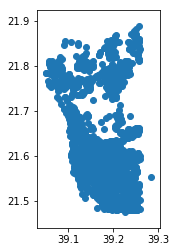

In [490]:
network_gdf_sm.plot()

In [486]:
network_gdf_sm.head()

x          y     distance                       geometry
id                                                                         
287894981  39.152753  21.630046   972.318970   POINT (39.152753 21.6300455)
289244719  39.166558  21.577636  2390.298096  POINT (39.1665584 21.5776362)
292262619  39.158164  21.523231  2500.000000  POINT (39.1581645 21.5232311)
292263927  39.159066  21.529212  2500.000000  POINT (39.1590662 21.5292116)
292271995  39.156890  21.528503  2500.000000   POINT (39.1568901 21.528503)

In [498]:
parks_jeddah.head()

Name_E          E          N Area_m2                      geometry
0  Aba Al Khaiyl  39.198446  21.600360   6,580    POINT (39.198446 21.60036)
1     Al Ajaweed  39.299186  21.397891   4,200  POINT (39.299186 21.3978907)
2       Al Ahwal  39.170122  21.623820   4,021    POINT (39.170122 21.62382)
3      Al Odabaa  39.211074  21.560264   6,750   POINT (39.211074 21.560264)
4      Al Ashbal  39.193307  21.536075   1,955   POINT (39.193307 21.536075)

In [487]:
objects_gdf.head()

y          x                             geometry
0  39.161931  21.564766  POINT (39.1619312837 21.5647655118)
1  39.199117  21.564766  POINT (39.1991167589 21.5647655118)
2  39.199117  21.583360  POINT (39.1991167589 21.5833603741)
3  39.161931  21.583360  POINT (39.1619312837 21.5833603741)
4  39.161931  21.564766  POINT (39.1619312837 21.5647655118)

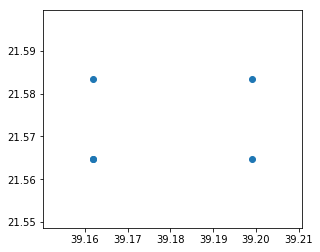

In [484]:
objects = [[39.1619312837,21.5647655118],[39.1991167589,21.5647655118],[39.1991167589,21.5833603741],[39.1619312837,21.5833603741],[39.1619312837,21.5647655118]]
objects_gdf = gpd.GeoDataFrame(objects, columns = ['y', 'x'])
objects_gdf['geometry'] = list(zip(objects_gdf.y, objects_gdf.x))
objects_gdf.geometry = objects_gdf.geometry.apply(lambda x: Point(x))
objects_gdf.plot()

In [485]:
ax = objects_gdf.plot()
mpll.display(fig = ax.figure, crs = {'init':'epsg:4236'})

network_gdf_sm.head()

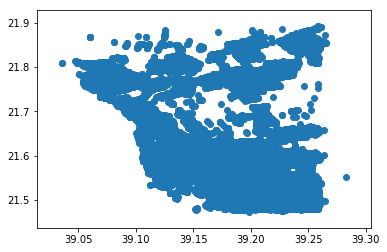

In [427]:
plt.scatter(network_gdf.x, network_gdf.y)

In [426]:
parks_jeddah.head()

Name_E          E          N Area_m2                      geometry
0  Aba Al Khaiyl  39.198446  21.600360   6,580    POINT (39.198446 21.60036)
1     Al Ajaweed  39.299186  21.397891   4,200  POINT (39.299186 21.3978907)
2       Al Ahwal  39.170122  21.623820   4,021    POINT (39.170122 21.62382)
3      Al Odabaa  39.211074  21.560264   6,750   POINT (39.211074 21.560264)
4      Al Ashbal  39.193307  21.536075   1,955   POINT (39.193307 21.536075)

In [395]:
def net_query(network, distance):
    access_table = network.nearest_pois(distance=distance, 
                                         category="all", 
                                         num_pois=1,
                                         max_distance=0)
    network.plot(access_table[1], 
         plot_type='scatter',
         fig_kwargs={'figsize':[20,14]},
         plot_kwargs={'cmap':'gist_heat_r','s':8,'edgecolor':'none'})

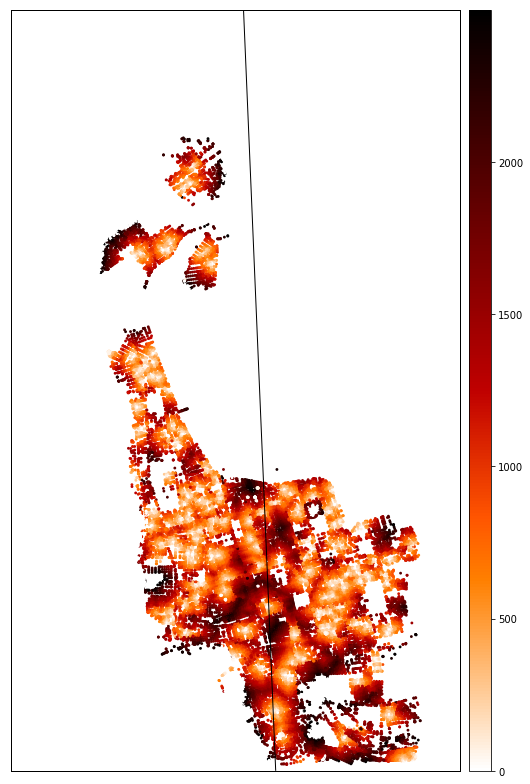

In [399]:
net_query(G_jeddah, 2500)

In [391]:
v = interact(net_query,distance=FloatSlider(min=0, max=10000, step=1000,continuous_update=False))
display(v)

ValueError: cannot find widget or abbreviation for argument: 'network'

In [388]:
from ipywidgets import FloatSlider, interact

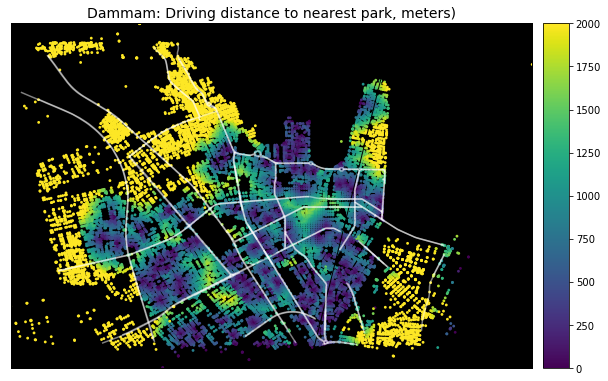

In [356]:
plot_accessibility_and_roads(G_dammam, parks_dammam, 2000, 1, 'Dammam')

In [314]:
parks_jeddah.dropna(inplace=True)

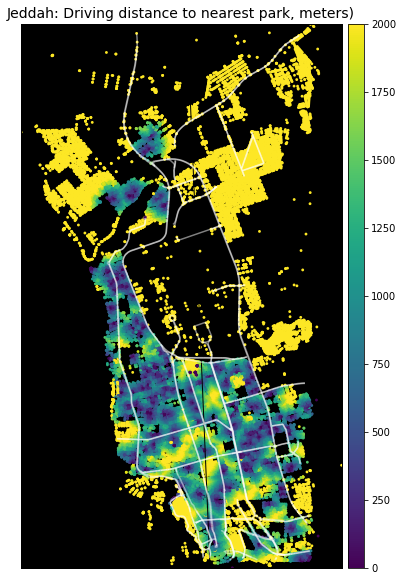

In [357]:
plot_accessibility_and_roads(G_jeddah, parks_jeddah, 2000, 1, 'Jeddah')

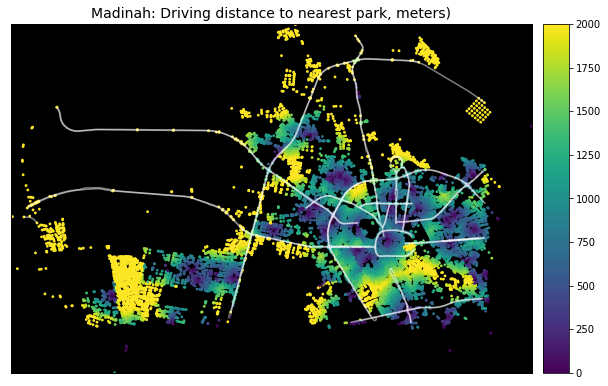

In [358]:
plot_accessibility_and_roads(G_madinah, parks_madinah, 2000, 1, 'Madinah')

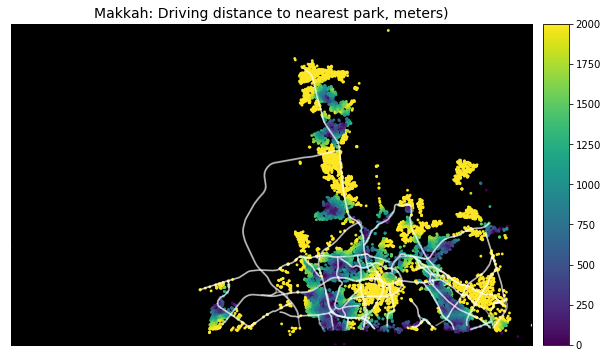

In [362]:
plot_accessibility_and_roads(G_makkah, parks_makkah, 2000, 1, 'Makkah')

In [319]:
parks_riyadh.dropna(inplace=True)

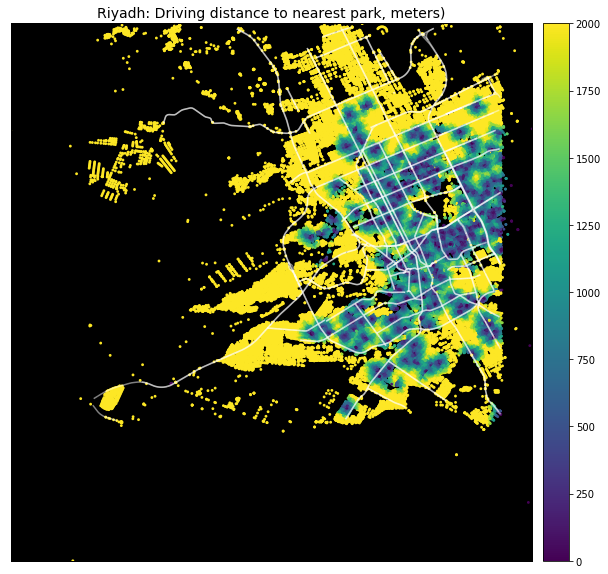

In [360]:
plot_accessibility_and_roads(G_riyadh, parks_riyadh, 2000, 1, 'Riyadh')

In [ ]:
plot_accessibility(G, parks_dammam, 2000, 1, 'Dammam')

Variables to define:
 - distance: compute accessibility within this distance from any point
 - num_pois: calculate distance to this many amenities [ie. to first, second, third ... n amenities]

In [281]:
G_dammam.set_pois(category='all', maxdist = distance,x_col=parks_dammam['E'], maxitems=1, y_col=parks_dammam['N'])
#network.set_pois(category='hospital', maxdist = distance,maxitems = num_pois,
#                 x_col=pois[pois.amenity.isin(['hospital'])]['lon'], 
#                             y_col=pois[pois.amenity.isin(['hospital'])]['lat'])

all_access = G_dammam.nearest_pois(distance=distance, category='all', num_pois=1)
#hosp_access = network.nearest_pois(distance=distance, category='hospital', num_pois=num_pois)
print('{:,} nodes'.format(len(all_access)))

17,177 nodes


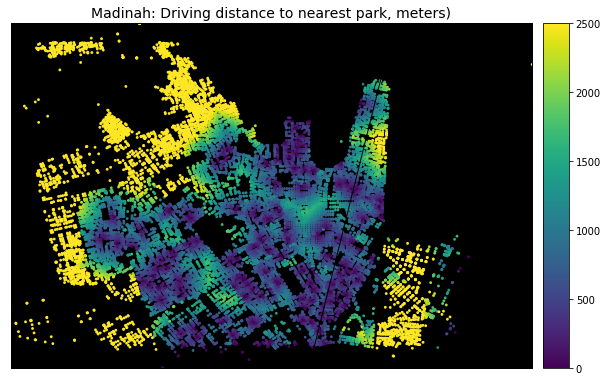

In [278]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = G_dammam.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
ax.set_facecolor('k')
#shp.plot(color='r',ax = ax)
ax.set_title('Madinah: Driving distance to nearest park, meters)', fontsize=14);

In [148]:
make_fishnet('grid.shp',*coords,500,500) # takes xmin, xmax, ymin, ymax

In [151]:
grid=gpd.read_file('grid.shp')
#ax = grid.plot(facecolor='w',edgecolor='b',lw=0.1)
#nodes_gdf.plot(ax=ax)
#shp.plot(ax=ax,color='r')
#ax.set_title('Street network and POIs: nodes in blue, POIs in red');

In [153]:
coords

(24.25, 39.4, 24.65, 39.8)

In [152]:
grid.shape

(10341618, 2)

In [ ]:
grid['centroid'] = grid.geometry.centroid

In [ ]:
grid['nearest_node'] = np.nan
grid['nearest_node'] = network.get_node_ids(grid.centroid.x,grid.centroid.y,mapping_distance=10)
grid.isnull().sum()

In [ ]:

distances = []
for i in range(grid.shape[0]):
    node = grid.nearest_node[i]
    distance = all_access.loc[node,1]
    distances.append(distance)  

In [179]:
G = ox.graph_from_address("Madinah, Saudi Arabia", distance=20000)

In [180]:
gdf = ox.graph_to_gdfs(G, nodes=False, edges = True)

In [181]:
gdf['highway'] = gdf.highway.astype(str)

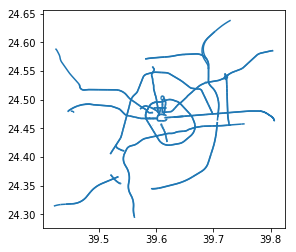

In [182]:
gdf[gdf.highway.isin(['motorway','trunk','primary'])].plot()

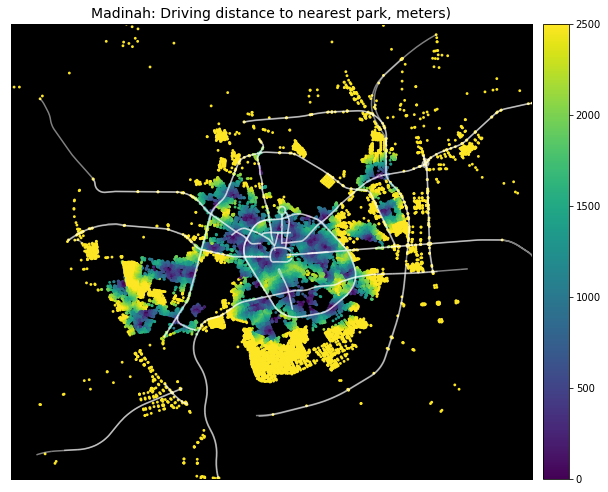

In [183]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
ax.set_facecolor('k')
gdf[gdf.highway.isin(['motorway','trunk','primary'])].plot(ax = ax, color = 'w', alpha = 0.5)
#shp.plot(color='r',ax = ax)
ax.set_title('Madinah: Driving distance to nearest park, meters)', fontsize=14);